# CNN and MLP Ensembling

- try CNN for images
- try MLP for features

## Preprocess Data

In [142]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [143]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv("images.csv")

# Split into features for MLP and image paths for CNN
image_paths = df['Path']
features = df.drop(columns=['Unnamed: 0', 'Path', 'Target', 'Image_Name']).values
targets = df['Target'].values

# Encode labels
label_encoder = LabelEncoder()
targets_encoded = label_encoder.fit_transform(targets)

# Split the data
X_train_img, X_test_img, X_train_feat, X_test_feat, y_train, y_test = train_test_split(
    image_paths, features, targets_encoded, test_size=0.3, random_state=42
)

print(f"Image training set: {X_train_img.shape}")
print(f"Feature training set: {X_train_feat.shape}")
print(f"Target training set: {y_train.shape}")


Image training set: (339,)
Feature training set: (339, 17)
Target training set: (339,)


In [144]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

# # Load the dataset
# df = pd.read_csv("images.csv")

# # Split the data into features (X) and targets (y) first
# features = df.drop(columns=['Unnamed: 0', 'Path', 'Target', 'Image_Name'])
# targets = df['Target']

# # Encode the target labels
# label_encoder = LabelEncoder()
# targets_encoded = label_encoder.fit_transform(targets)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     features, targets_encoded, test_size=0.3, random_state=42, stratify=targets_encoded
# )

# # Now split the features into image paths and other features
# X_train_img = df.loc[X_train.index, 'Path']
# X_test_img = df.loc[X_test.index, 'Path']

# X_train_feat = X_train.values
# X_test_feat = X_test.values

# # Check the splits
# print(f"Image training set size: {len(X_train_img)}")
# print(f"Feature training set size: {X_train_feat.shape}")
# print(f"Target training set size: {y_train.shape}")



## CNN Model

In [145]:
import numpy as np
from tensorflow.keras.utils import img_to_array, load_img

def preprocess_images(image_paths, target_size=(128, 128)):
    images = []
    for path in image_paths:
        # Load and preprocess each image
        image = load_img(path, target_size=target_size)
        image = img_to_array(image) / 255.0  # Normalize
        images.append(image)
    return np.array(images)

# Preprocess images
X_train_cnn = preprocess_images(X_train_img)
X_test_cnn = preprocess_images(X_test_img)

print(f"CNN Input Shape: {X_train_cnn.shape}")

CNN Input Shape: (339, 128, 128, 3)


In [146]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define CNN model with updated hyperparameters
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout rate set to 0.3 as per best parameters
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with updated learning rate
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with updated epochs and batch size
cnn_model.fit(X_train_cnn, y_train, epochs=5, batch_size=32, validation_split=0.1)

# CNN Predictions
cnn_predictions = cnn_model.predict(X_test_cnn).flatten()

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.5313 - loss: 0.6986 - val_accuracy: 0.4706 - val_loss: 0.7516
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.5599 - loss: 0.6942 - val_accuracy: 0.7059 - val_loss: 0.6629
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.6574 - loss: 0.6454 - val_accuracy: 0.6471 - val_loss: 0.6587
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.6769 - loss: 0.6046 - val_accuracy: 0.6471 - val_loss: 0.6499
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.7064 - loss: 0.5861 - val_accuracy: 0.7059 - val_loss: 0.6307
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [147]:
from sklearn.metrics import accuracy_score

cnn_predictions_binary = (cnn_predictions > 0.5).astype(int) # convert to 0 or 1
cnn_accuracy = accuracy_score(y_test, cnn_predictions_binary)
print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")

CNN Test Accuracy: 0.6849


In [148]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt

cnn_predictions_binary = (cnn_predictions > 0.5).astype(int) # convert to 0 or 1

cnn_accuracy = accuracy_score(y_test, cnn_predictions_binary)
cnn_precision = precision_score(y_test, cnn_predictions_binary)
cnn_recall = recall_score(y_test, cnn_predictions_binary)
cnn_roc_auc = roc_auc_score(y_test, cnn_predictions)
cnn_f1_score = f1_score(y_test, cnn_predictions_binary)

print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")
print(f"CNN Test Precision: {cnn_precision:.4f}")
print(f"CNN Test Recall: {cnn_recall:.4f}")
print(f"CNN Test ROC-AUC: {cnn_roc_auc:.4f}")
print(f"CNN Test F1 Score: {cnn_f1_score:.4f}")

CNN Test Accuracy: 0.6849
CNN Test Precision: 0.7400
CNN Test Recall: 0.5286
CNN Test ROC-AUC: 0.7385
CNN Test F1 Score: 0.6167


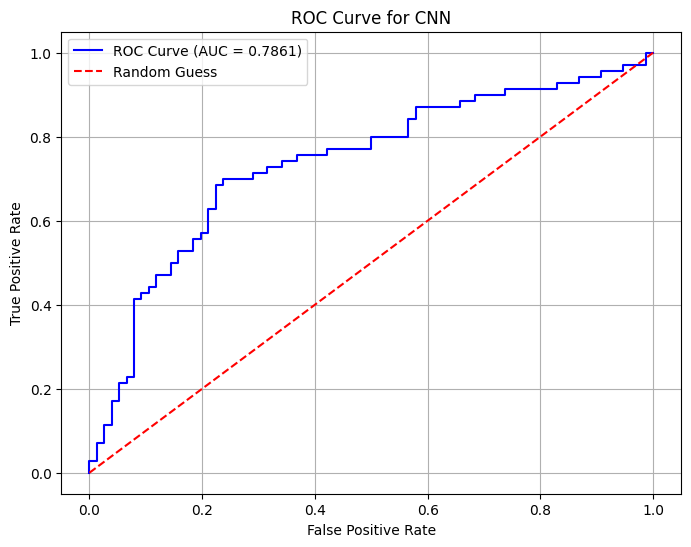

In [149]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, cnn_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend()
plt.grid()
plt.show()

CNN model performs well (AUC = 0.7267) and is much better than random guessing, though there is room for improvement.

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.7431 - loss: 0.5529 - val_accuracy: 0.7647 - val_loss: 0.6162
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.7627 - loss: 0.5395 - val_accuracy: 0.6765 - val_loss: 0.6074
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.8212 - loss: 0.4875 - val_accuracy: 0.6765 - val_loss: 0.6359
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.7809 - loss: 0.4752 - val_accuracy: 0.6765 - val_loss: 0.6036
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7789 - loss: 0.4650 - val_accuracy: 0.6765 - val_loss: 0.6575


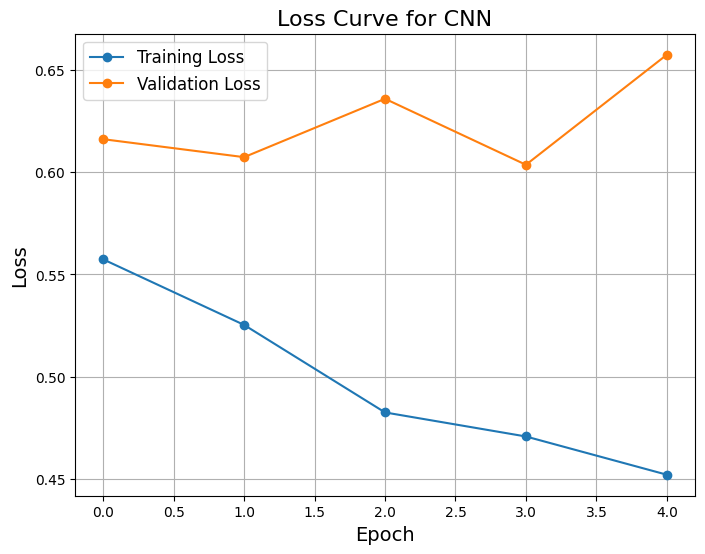

In [150]:
import matplotlib.pyplot as plt

# Train the CNN and save the history
history = cnn_model.fit(X_train_cnn, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Extract the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Loss Curve for CNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

This graph shows the training loss (blue line) and validation loss (orange line) over 5 epochs during the training of our CNN model. The training loss decreases steadily across epochs, which indicates that the model is learning the patterns in the training data. The validation loss initially decreases, showing that the model is improving on unseen data. However, there is a spike in validation loss at epoch 3, which may indicate instability or temporary overfitting. By the final epoch, both the training and validation losses are at their lowest values, suggesting overall improvement in the model's performance.

The gap between the training and validation loss remains relatively small throughout, indicating that the model is not severely overfitting. This is a positive sign of generalization. The fluctuation in validation loss suggests that there might still be room for improvement, such as increasing training stability or refining hyperparameters.

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.5337 - loss: 0.6937 - val_accuracy: 0.4706 - val_loss: 0.6879 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.6682 - loss: 0.6234 - val_accuracy: 0.6471 - val_loss: 0.6462 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.6560 - loss: 0.6124 - val_accuracy: 0.7059 - val_loss: 0.6328 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.7348 - loss: 0.5664 - val_accuracy: 0.5588 - val_loss: 0.6695 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7146 - loss: 0.5568 - val_accuracy: 0.6471 - val_loss: 0.6488 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.7150 - loss: 0.5328 - val_accuracy: 0.7059 - val_loss: 0.5974 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.7903 - lo

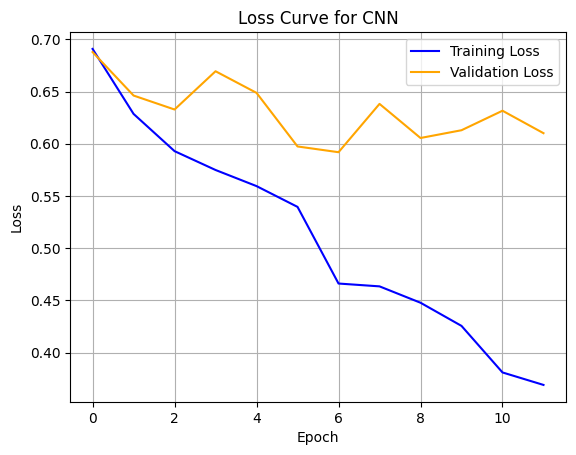

In [151]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping and reduce learning rate on plateau callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,  # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best model weights
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.5,  # Reduce learning rate by 50%
    patience=3,  # Wait 3 epochs for no improvement
    min_lr=1e-6  # Minimum learning rate limit
)

# Define the CNN model as before
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout rate set to 0.3 as per best parameters
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with updated learning rate
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with callbacks (early stopping and reduce learning rate)
history = cnn_model.fit(
    X_train_cnn, y_train, 
    epochs=50,  # Training for more epochs
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr]  # Include both callbacks
)

# CNN Predictions
cnn_predictions = cnn_model.predict(X_test_cnn).flatten()

# Optionally, you can plot the loss curve again after training with callbacks
import matplotlib.pyplot as plt

# Extract training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curve
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss Curve for CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


- improvement in the training loss. 
- However, the validation loss starting to rise indicates that further steps are needed to improve generalization.

Epoch 1/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.8459 - loss: 0.4369 - val_accuracy: 0.7647 - val_loss: 0.5950
Epoch 2/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.8634 - loss: 0.4232 - val_accuracy: 0.7353 - val_loss: 0.6031
Epoch 3/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.8586 - loss: 0.4189 - val_accuracy: 0.7353 - val_loss: 0.6028
Epoch 4/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.8925 - loss: 0.3781 - val_accuracy: 0.7059 - val_loss: 0.6071
Epoch 5/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.8627 - loss: 0.3885 - val_accuracy: 0.7059 - val_loss: 0.6075
Epoch 6/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.8509 - loss: 0.3888 - val_accuracy: 0.6765 - val_loss: 0.6379
Epoch 7/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8045 - loss: 0.4228 - val_accuracy: 0.7353 - val_loss: 0.6306
Epoch 8/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.8533 - loss: 0.3871 - val_accuracy: 0.

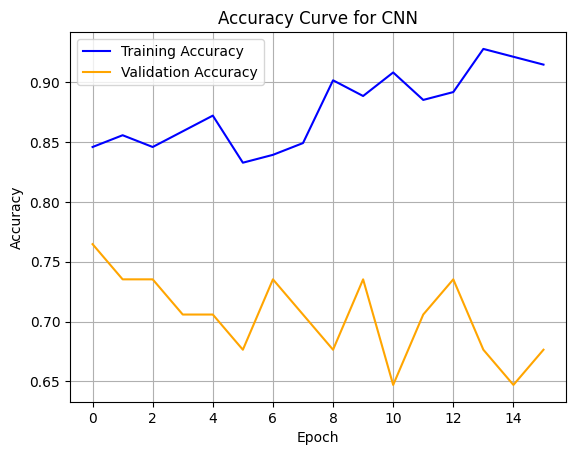

In [152]:
import matplotlib.pyplot as plt

# Train the model and store history
history = cnn_model.fit(X_train_cnn, y_train, epochs=16, batch_size=32, validation_split=0.1)

# Get the accuracy history from the training and validation data
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting the accuracy curve
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.title('Accuracy Curve for CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## MLP Model

In [153]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [154]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Define the pipeline with the best parameters from GridSearchCV
mlp_model = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale features
    ('mlp', MLPClassifier(
        activation='tanh',  # Best activation function
        alpha=0.0001,       # Best alpha (regularization strength)
        hidden_layer_sizes=(100, 50),  # Best hidden layer sizes
        learning_rate_init=0.01,  # Best learning rate
        solver='adam',           # Best solver
        max_iter=500,            # Best number of iterations
        random_state=42
    ))  # Step 2: Train MLP
])

# Fit the pipeline on the training data
mlp_model.fit(X_train_feat, y_train)

# Predict on the test set
mlp_predictions = mlp_model.predict(X_test_feat)

MLP Test Accuracy: 0.8082
MLP Test Precision: 0.7324
MLP Test Recall: 0.7429
MLP Test ROC-AUC: 0.7861
MLP Test F1 Score: 0.7376


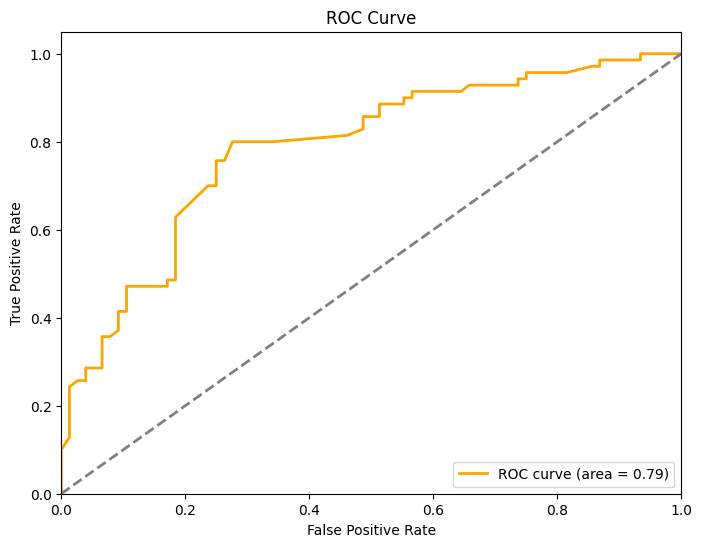

In [155]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

mlp_predictions_proba = mlp_model.predict_proba(X_test_feat)[:, 1]
mlp_predictions = (mlp_predictions_proba >= 0.5).astype(int)

# Calculate precision and recall
mlp_precision = precision_score(y_test, mlp_predictions)
mlp_recall = recall_score(y_test, mlp_predictions)
mlp_roc_auc = roc_auc_score(y_test, mlp_predictions_proba)
mlp_f1_score = f1_score(y_test, mlp_predictions)

print(f"MLP Test Accuracy: {mlp_accuracy:.4f}")
print(f"MLP Test Precision: {mlp_precision:.4f}")
print(f"MLP Test Recall: {mlp_recall:.4f}")
print(f"MLP Test ROC-AUC: {mlp_roc_auc:.4f}")
print(f"MLP Test F1 Score: {mlp_f1_score:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, mlp_predictions_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Precision and Recall are both decent, with your model being reasonably good at identifying positives (recall = 0.7429) while also maintaining a good level of correctness in its positive predictions (precision = 0.7324).

The ROC-AUC score of 0.7861 suggests that the model is reasonably good at distinguishing between positive and negative classes, though there might still be room for improvement.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature nam

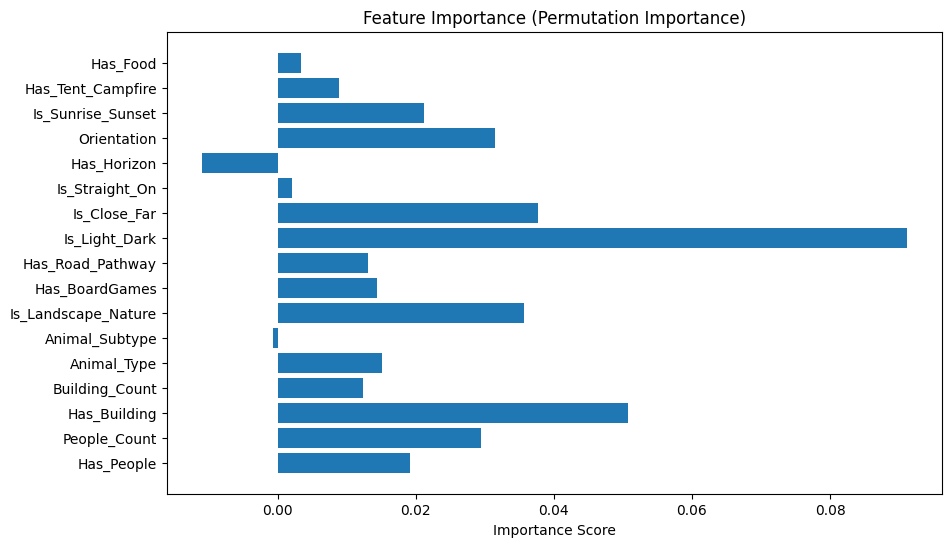

In [156]:
# Assuming df is the original DataFrame
features_df = df.drop(columns=['Unnamed: 0', 'Path', 'Target', 'Image_Name'])
feature_names = features_df.columns.tolist()

X_test_feat_df = pd.DataFrame(X_test_feat, columns=feature_names)

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Compute permutation importance
results = permutation_importance(mlp_model, X_test_feat_df, y_test, n_repeats=10, random_state=42)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(results.importances_mean)), results.importances_mean)
plt.yticks(range(len(results.importances_mean)), feature_names)  # Correct the mapping to feature names
plt.xlabel('Importance Score')
plt.title('Feature Importance (Permutation Importance)')
plt.show()


## Ensembling Part?

In [157]:
from sklearn.metrics import accuracy_score

# Simple Averaging for ensemble predictions
weights = [0.5, 0.5]  # Equal weights for CNN and MLP
combined_predictions = (weights[0] * cnn_predictions) + (weights[1] * mlp_predictions)
final_predictions = (combined_predictions > 0.5).astype(int)

# Evaluate the ensemble model's accuracy
ensemble_accuracy = accuracy_score(y_test, final_predictions)
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")


Ensemble Accuracy: 0.7466


In [158]:
import numpy as np
from sklearn.metrics import accuracy_score

# Define a grid of weights
weights = np.linspace(0, 1, 21)  # 21 values from 0.0 to 1.0

best_accuracy = 0
best_weights = (0.5, 0.5)  # Default to equal weights

for cnn_weight in weights:
    mlp_weight = 1 - cnn_weight  # Ensure weights sum to 1
    combined_predictions = (cnn_weight * cnn_predictions) + (mlp_weight * mlp_predictions)
    final_predictions = (combined_predictions > 0.5).astype(int)
    accuracy = accuracy_score(y_test, final_predictions)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights = (cnn_weight, mlp_weight)

print(f"Best Weights: CNN={best_weights[0]}, MLP={best_weights[1]}")
print(f"Best Ensemble Accuracy: {best_accuracy:.4f}")


Best Weights: CNN=0.0, MLP=1.0
Best Ensemble Accuracy: 0.7466


In [159]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming cnn_predictions and mlp_predictions are the predicted probabilities (not raw predictions)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_accuracy = 0
best_weights = (0.5, 0.5)

# List of weights to iterate over
weights = np.linspace(0, 1, num=11)  # Example weights: [0.0, 0.1, ..., 1.0]

for cnn_weight in weights:
    mlp_weight = 1 - cnn_weight
    fold_accuracies = []
    
    for train_index, test_index in kf.split(cnn_predictions, y_test):  # Pass features and labels
        # Create train/test splits for cross-validation
        cnn_train, cnn_test = cnn_predictions[train_index], cnn_predictions[test_index]
        mlp_train, mlp_test = mlp_predictions[train_index], mlp_predictions[test_index]
        y_train_fold, y_test_fold = y_test[train_index], y_test[test_index]
        
        # Combine predictions for the fold
        combined_test = (cnn_weight * cnn_test) + (mlp_weight * mlp_test)
        final_test = (combined_test > 0.5).astype(int)  # Convert probabilities to binary predictions
        fold_accuracy = accuracy_score(y_test_fold, final_test)
        fold_accuracies.append(fold_accuracy)
    
    # Average accuracy across folds
    mean_accuracy = np.mean(fold_accuracies)
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_weights = (cnn_weight, mlp_weight)

print(f"Best Weights from Cross-Validation: CNN={best_weights[0]}, MLP={best_weights[1]}")
print(f"Best Cross-Validated Accuracy: {best_accuracy:.4f}")


Best Weights from Cross-Validation: CNN=0.0, MLP=1.0
Best Cross-Validated Accuracy: 0.7469


In [160]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Prepare meta-model features
meta_features = np.column_stack((cnn_predictions, mlp_predictions))

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs']
}

# Perform grid search
meta_model = LogisticRegression(random_state=42)
# grid_search = GridSearchCV(meta_model, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(meta_features, y_test)

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(meta_model, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
grid_search.fit(meta_features, y_test)


print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Meta-Model Accuracy: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 0.01, 'solver': 'liblinear'}
Best Meta-Model Accuracy: 0.7471


In [161]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

# Simple Averaging for ensemble predictions
weights = [0.5, 0.5]  # Equal weights for CNN and MLP
combined_predictions = (weights[0] * cnn_predictions) + (weights[1] * mlp_predictions)
final_predictions = (combined_predictions > 0.5).astype(int)

# Evaluate the ensemble model's accuracy
ensemble_accuracy = accuracy_score(y_test, final_predictions)
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

# Calculate Precision, Recall, and F1-Score
ensemble_precision = precision_score(y_test, final_predictions, average='binary')  # 'binary' for binary classification
ensemble_recall = recall_score(y_test, final_predictions, average='binary')
ensemble_f1_score = f1_score(y_test, final_predictions, average='binary')

# Print the metrics
print(f"Precision: {ensemble_precision:.4f}")
print(f"Recall: {ensemble_recall:.4f}")
print(f"F1-Score: {ensemble_f1_score:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:")
print(cm)


Ensemble Accuracy: 0.7466
Precision: 0.7324
Recall: 0.7429
F1-Score: 0.7376
Confusion Matrix:
[[57 19]
 [18 52]]


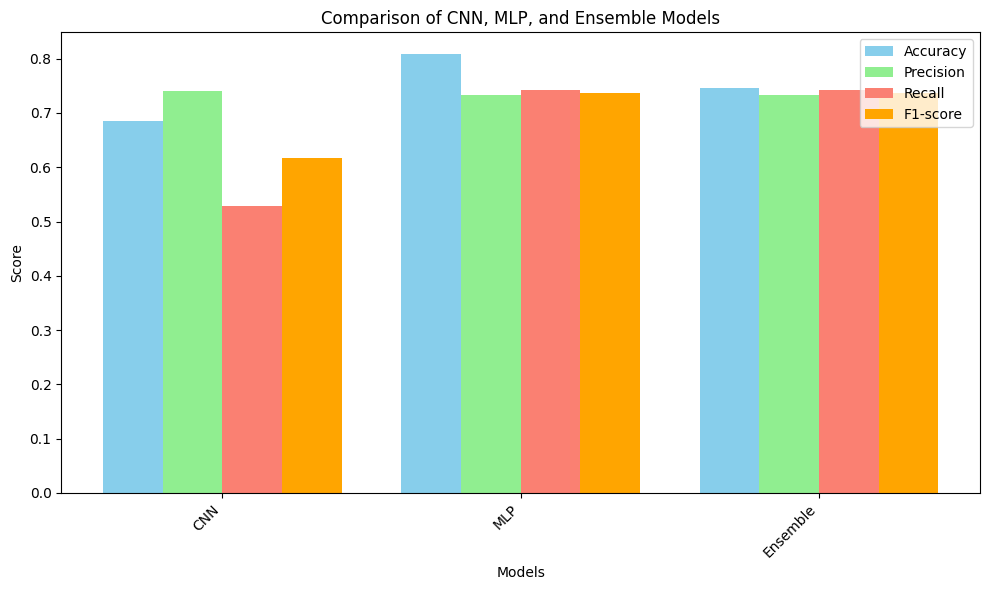

In [162]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['CNN', 'MLP', 'Ensemble']

# Performance metrics (Accuracy, Precision, Recall, F1-score)
accuracy = [cnn_accuracy, mlp_accuracy, ensemble_accuracy]
precision = [cnn_precision, mlp_precision, ensemble_precision]
recall = [cnn_recall, mlp_recall, ensemble_recall]
f1_score = [cnn_f1_score, mlp_f1_score, ensemble_f1_score]

# Set positions for the bars
x = np.arange(len(models))

# Bar width
width = 0.2

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each metric
ax.bar(x - 1.5*width, accuracy, width, label='Accuracy', color='skyblue')
ax.bar(x - 0.5*width, precision, width, label='Precision', color='lightgreen')
ax.bar(x + 0.5*width, recall, width, label='Recall', color='salmon')
ax.bar(x + 1.5*width, f1_score, width, label='F1-score', color='orange')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Comparison of CNN, MLP, and Ensemble Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


# Try on holdout sets!!

In [163]:
feature_test = pd.read_csv('features_test.csv')
# unlabelled_test = pd.read_csv('unlabelled_images.csv')
# merge those later

column_mapping = {
    'image_name': 'Image_Name',
    'People(y/n)': 'Has_People',
    'People hm': 'People_Count',
    'Building(y/n)': 'Has_Building',
    'Building hm': 'Building_Count',
    'Animal': 'Animal_Type',
    'type of an': 'Animal_Subtype',
    'Landscape/Nature?': 'Is_Landscape_Nature',
    'Board Games': 'Has_BoardGames',
    'Road/Pathway': 'Has_Road_Pathway',
    'Light/Dark?': 'Is_Light_Dark',
    'Close/Far': 'Is_Close_Far',
    'Straight on/not': 'Is_Straight_On',
    'Horizon (0=none, 1=horizon)': 'Has_Horizon',
    'Orientation (0=horiz, 1=vert)': 'Orientation',
    'Sunrise/Sunset': 'Is_Sunrise_Sunset',
    'Tent/Campfire': 'Has_Tent_Campfire',
    'Food': 'Has_Food'
}
feature_test = feature_test.rename(columns=column_mapping)


feature_test = feature_test.drop(columns=['Image_Name'])
feature_test.head()

mlp_model.fit(X_train_feat, y_train)  # Train the model if not already trained
mlp_model.predict(feature_test)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1])

# Visuals!